In [381]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [139]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [140]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [141]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

In [273]:
result = pd.read_csv('predictions_basic1.csv', sep=';')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,[ 991358 1050543 861603 958137 870195],[ 999999 6534178 6533889 1029743 6534166],[ 981760 1127831 1098066 826249 878996],[ 981760 1127831 1098066 878996 826249],[ 981760 1127831 1098066 826249 878996],[ 999999 1082185 1029743 995785 1004906]
1,3,[ 835476 851057 872021 878302 879948 ...,[ 990440 1135573 9547021 1081355 9802540],[ 999999 6534178 6533889 1029743 6534166],[ 981760 995242 1029743 840361 961554],[ 981760 1004906 961554 1096036 1080414],[ 981760 1004906 859075 1096036 961554],[ 999999 1082185 1098066 6534178 1127831]


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [143]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [144]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    items = items_weights['item_id'].to_list()
    weights = items_weights['weight'].to_list()
    
    recs = np.random.choice(items, size=n, replace=False, p=weights)
    
    return recs.tolist()

In [274]:
items_value = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_value['weight'] = np.log(items_value['sales_value'] + 1e-6)
items_value.loc[items_value['weight']<0, 'weight'] = 0
whole_sum = items_value['weight'].sum()
items_value['weight'] = items_value['weight'] / whole_sum
items_value.drop('sales_value', axis=1, inplace=True)

In [275]:
items_value['weight'].sum()

1.0

In [276]:
%%time
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: 
                                                                   np.array(weighted_random_recommendation(items_value, n=5)))
result.head(2)

Wall time: 23.8 s


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,[ 821867 834484 856942 865456 889248 ...,[ 991358 1050543 861603 958137 870195],[ 999999 6534178 6533889 1029743 6534166],[ 981760 1127831 1098066 826249 878996],[ 981760 1127831 1098066 878996 826249],[ 981760 1127831 1098066 826249 878996],[ 999999 1082185 1029743 995785 1004906],"[1128325, 8090519, 889333, 12729545, 12132199]"
1,3,[ 835476 851057 872021 878302 879948 ...,[ 990440 1135573 9547021 1081355 9802540],[ 999999 6534178 6533889 1029743 6534166],[ 981760 995242 1029743 840361 961554],[ 981760 1004906 961554 1096036 1080414],[ 981760 1004906 859075 1096036 961554],[ 999999 1082185 1098066 6534178 1127831],"[1014919, 996723, 15926306, 914483, 979975]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [399]:
def precision_at_k(recommended_list, bought_list, k=5):
    if not ',' in bought_list:
        bought_list = '[' + ', '.join(bought_list[1:].split())
    bought_list = np.array(json.loads(bought_list))
    
    if not ',' in recommended_list and type(recommended_list) == str:
        recommended_list = '[' + ', '.join(recommended_list[1:].split())
        recommended_list = np.array(json.loads(recommended_list))[:k]
    else:
        recommended_list = recommended_list[:k]
        
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / k
    
    return precision

In [398]:
def pr_at_k(x):
    res_lst = []
    for a in algs:
        res_lst.append(precision_at_k(x[a], x['actual']))
    return res_lst

In [277]:
algs = list(result.columns)[2:]
algs

['random_recommendation',
 'popular_recommendation',
 'itemitem',
 'cosine',
 'tfidf',
 'own_purchases',
 'weighted_random_recommendation']

In [278]:
result['presicion_at_5'] = result.apply(pr_at_k, axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


In [279]:
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,presicion_at_5
0,1,[ 821867 834484 856942 865456 889248 ...,[ 991358 1050543 861603 958137 870195],[ 999999 6534178 6533889 1029743 6534166],[ 981760 1127831 1098066 826249 878996],[ 981760 1127831 1098066 878996 826249],[ 981760 1127831 1098066 826249 878996],[ 999999 1082185 1029743 995785 1004906],"[1128325, 8090519, 889333, 12729545, 12132199]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0]"
1,3,[ 835476 851057 872021 878302 879948 ...,[ 990440 1135573 9547021 1081355 9802540],[ 999999 6534178 6533889 1029743 6534166],[ 981760 995242 1029743 840361 961554],[ 981760 1004906 961554 1096036 1080414],[ 981760 1004906 859075 1096036 961554],[ 999999 1082185 1098066 6534178 1127831],"[1014919, 996723, 15926306, 914483, 979975]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,[15926844 923780 10121610 1031633 985234],[ 999999 6534178 6533889 1029743 6534166],[1098066 826249 1106523 923746 1058997],[1098066 826249 860776 854852 1068719],[1098066 826249 860776 1068719 916122],[ 999999 1082185 1029743 6534178 1127831],"[1057391, 899502, 918345, 6979255, 946479]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,7,[ 840386 889774 898068 909714 929067 ...,[ 837527 1079228 1070463 888476 827570],[ 999999 6534178 6533889 1029743 6534166],[ 981760 1098066 840361 883404 916122],[ 981760 1098066 883404 1004906 859075],[ 981760 883404 1098066 859075 916122],[ 999999 1082185 1029743 1127831 995785],"[933736, 5564754, 10181534, 1054992, 10355732]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0]"
4,8,[ 835098 872137 910439 924610 992977 ...,[ 979585 6773238 9859052 1112627 1135573],[ 999999 6534178 6533889 1029743 6534166],[ 904360 13115903 13189726 13190294 15596515],[ 904360 5588666 1096036 979707 1013321],[ 904360 1096036 5588666 979707 1013321],[ 999999 1082185 1029743 1098066 6534178],"[905081, 9796938, 9396667, 1105613, 938463]","[0.0, 0.2, 0.0, 0.2, 0.2, 0.4, 0.0]"


In [280]:
algs

['random_recommendation',
 'popular_recommendation',
 'itemitem',
 'cosine',
 'tfidf',
 'own_purchases',
 'weighted_random_recommendation']

In [281]:
pat5_cols = ['p_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_5'].tolist(), index=result.index)

In [282]:
result.describe()

,user_id,p_at_5_random_recommendation,p_at_5_popular_recommendation,p_at_5_itemitem,p_at_5_cosine,p_at_5_tfidf,p_at_5_own_purchases,p_at_5_weighted_random_recommendation
count,2042.000000,2042.000000,2042.000000,2042.000000,2042.000000,2042.000000,2042.000000,2042.000000
mean,1257.930950,0.004897,0.085602,0.033595,0.035260,0.036043,0.179628,0.001077
std,718.052041,0.031545,0.126454,0.085772,0.087261,0.087390,0.189525,0.014643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,648.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1260.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000
75%,1879.750000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000
max,2500.000000,0.400000,0.600000,0.600000,0.600000,0.600000,0.800000,0.200000


Судя по среднему значению presicion@5 лучше всего сработал алгоритм ItemItem среди собственных покупок юзера - __own_purchases__

И это единственный алгоритм, который обошел бейзлайн __popular_recommendation__

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*

In [283]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [342]:
items_value.sort_values('weight', ascending=False, inplace=True)
items = np.array(items_value['item_id'].values)
top_lst = [2000, 5000, 10000]
col_rec_bl = ['random_recommendation', 'popular_recommendation', 'weighted_random_recommendation']

In [319]:
items_top = data_train.groupby('item_id')['sales_value'].sum().reset_index()
# items_top['weight'] = np.log(items_top['sales_value'] + 1e-6)
items_top.sort_values('sales_value', ascending=False, inplace=True)
items_top.head(3)

,item_id,sales_value
55470,6534178,447799.94
55430,6533889,40483.34
28895,1029743,35764.66


In [323]:
%%time

cols_top_lst = []
for i in top_lst:
    items_top_n = items_top[:i]
    items_top_n['weight'] = np.log(items_top_n['sales_value'] + 1e-6)
    items_top_n.loc[items_top_n['weight']<0, 'weight'] = 0
    whole_sum = items_top_n['weight'].sum()
    items_top_n['weight'] = items_top_n['weight'] / whole_sum
    items_top_n.drop('sales_value', axis=1, inplace=True)
    items = items_top_n['item_id'].values

    result[col_rec_bl[0] + '_' + str(i)] = result['user_id'].apply(lambda x: np.array(random_recommendation(items, n=5)))
    result[col_rec_bl[1] + '_' + str(i)] = result['user_id'].apply(lambda x: items[:5])
    result[col_rec_bl[2] + '_' + str(i)] = result['user_id'].apply(lambda x: 
                                                                   np.array(weighted_random_recommendation(items_top_n, n=5)))
    cols_top_lst.extend([col_rec_bl[0] + '_' + str(i),
                       col_rec_bl[0] + '_' + str(i),
                       col_rec_bl[0] + '_' + str(i)])
    
    result['presicion_at_top_5'] = result.apply(pr_at_k, axis=1)
    
result.head(2)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Рустам\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Wall time: 5.36 s


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,presicion_at_5,...,p_at_5_weighted_random_recommendation,random_recommendation_2000,random_recommendation_5000,random_recommendation_10000,popular_recommendation_2000,popular_recommendation_5000,popular_recommendation_10000,weighted_random_recommendation_2000,weighted_random_recommendation_5000,weighted_random_recommendation_10000
0,1,[ 821867 834484 856942 865456 889248 ...,[ 991358 1050543 861603 958137 870195],[ 999999 6534178 6533889 1029743 6534166],[ 981760 1127831 1098066 826249 878996],[ 981760 1127831 1098066 878996 826249],[ 981760 1127831 1098066 826249 878996],[ 999999 1082185 1029743 995785 1004906],"[1128325, 8090519, 889333, 12729545, 12132199]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0]",...,0.0,"[851819, 854405, 1055425, 908213, 937210]","[963683, 891516, 825226, 9526673, 885023]","[1093355, 1103187, 963194, 1123086, 1127611]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[968072, 902396, 1115576, 1123792, 995151]","[1022374, 870559, 6979427, 1137775, 891423]","[1059969, 1096795, 863506, 9396750, 845082]"
1,3,[ 835476 851057 872021 878302 879948 ...,[ 990440 1135573 9547021 1081355 9802540],[ 999999 6534178 6533889 1029743 6534166],[ 981760 995242 1029743 840361 961554],[ 981760 1004906 961554 1096036 1080414],[ 981760 1004906 859075 1096036 961554],[ 999999 1082185 1098066 6534178 1127831],"[1014919, 996723, 15926306, 914483, 979975]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,0.0,"[1025611, 837107, 12301839, 907128, 6424471]","[974204, 12302069, 900072, 831888, 1045478]","[981760, 863324, 884774, 5570685, 965679]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1058779, 1042438, 832001, 865528, 869177]","[12984576, 866540, 957420, 1046584, 1042544]","[1138467, 897285, 1098284, 907099, 923723]"


In [325]:
algs = cols_top_lst
result['presicion_at_top_5'] = result.apply(pr_at_k, axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


In [326]:
pat5_cols = ['p_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_top_5'].tolist(), index=result.index)

In [376]:
for_plot = []
for i in [0, 3, 6]:
    t = top_lst[int(i/3)]
    for n in range(3):
        for_plot.append([t, col_rec_bl[n], result[pat5_cols[i:i+3][n]].mean()])
for_plot_df = pd.DataFrame(for_plot, columns=['TOP', 'baseline', 'presision_at_5'])
for_plot_df.set_index('TOP', inplace=True)
for_plot_df

,baseline,presision_at_5
TOP,,
2000,random_recommendation,0.011166
2000,popular_recommendation,0.155240
2000,weighted_random_recommendation,0.009990
5000,random_recommendation,0.006268
5000,popular_recommendation,0.155240
5000,weighted_random_recommendation,0.005877
10000,random_recommendation,0.002742
10000,popular_recommendation,0.155240
10000,weighted_random_recommendation,0.003820


In [377]:
p5 = []
for col in col_rec_bl:
    p5.append(for_plot_df.loc[for_plot_df['baseline']==col, 'presision_at_5'])

Text(0.5, 1.0, 'weighted_random_recommendation')

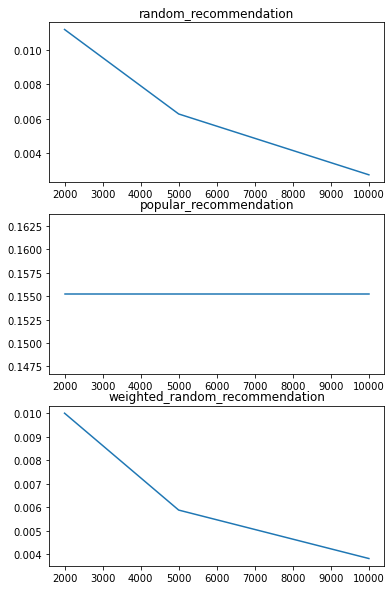

In [386]:
rcParams['figure.figsize'] = 6, 10
fig, axs = plt.subplots(3)
axs[0].plot(p5[0])
axs[0].set_title(col_rec_bl[0])
axs[1].plot(p5[1])
axs[1].set_title(col_rec_bl[1])
axs[2].plot(p5[2])
axs[2].set_title(col_rec_bl[2])


Baseline __popular_recommendation__ показывает самую высокую метрику precision@5, конечно же одинаковую, т.к. во всех случаях выводятся одни и те же 5 товаров. Но в целом с увеличением кол-ва товаров, по которым строится baseline, уменьшается precision@5.

- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [387]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [388]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [389]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\Рустам\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
user_item_matrix.shape

(2499, 5001)

In [391]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [392]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [394]:
%%time

k_lst = [3, 5, 7, 9, 11]

it_lst = []
for k in k_lst:
    model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                            user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                            N=5, # кол-во рекомендаций 
                            filter_already_liked_items=True, 
                            filter_items=None, 
                            recalculate_user=True)
    
    result['itemitem_'+str(k)] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])
    it_lst.append('itemitem_'+str(k))


Wall time: 4.61 s


In [400]:
algs = it_lst
result['presicion_at_itemitem_5'] = result.apply(pr_at_k, axis=1)

In [401]:
pat5_cols = ['p_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_itemitem_5'].tolist(), index=result.index)

In [402]:
pat5_cols

['p_at_5_itemitem_3',
 'p_at_5_itemitem_5',
 'p_at_5_itemitem_7',
 'p_at_5_itemitem_9',
 'p_at_5_itemitem_11']

In [408]:
for_plot = []
for i, n in zip(k_lst, pat5_cols):
    for_plot.append([i, result[n].mean()])
for_plot_df = pd.DataFrame(for_plot, columns=['K', 'presision_at_5'])
for_plot_df.set_index('K', inplace=True)
for_plot_df

,presision_at_5
K,
3,0.058472
5,0.033595
7,0.031440
9,0.030656
11,0.030362


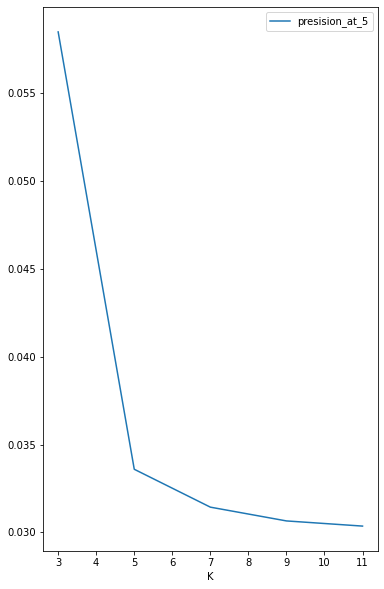

In [409]:
for_plot_df.plot()

Метрика увеличивается с уменьшением K ближайших соседей. Видимо, что похожесть пользователей уменьшается с увеличением соседей.